# Introduction

In this lab we will basically recreate the running example in Section 6.3 of Chollet.  The example is about forecasting the temperature using neural network models.  We'll use weather data from South Hadley instead of the data from Germany used in the book.  This is kindof a silly example (I think noone would really use a neural network for this; weather forecasting is done with differential equations models), but it illustrates the ideas.

The ideas we'll use are:

 * A baseline RNN
 * LSTM
 * GRU

# Imports

In [0]:
import pandas as pd
import numpy as np
from keras import models
from keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing
Here's a look at the data set, after filtering to data since the year 1970 and keeping only the variables we will use.

In [0]:
weather = pd.read_csv("http://www.evanlray.com/data/misc/south_hadley_weather/daily_weather.csv")
vars_to_keep = ['temp_avg_F', 'dew_pt_avg_F', 'humidity_avg_pct',
                'sea_level_press_avg_in', 'wind_avg_mph',
                'precipitation_in']
weather = weather.loc[:, vars_to_keep]

In [0]:
weather.head()

,temp_avg_F,dew_pt_avg_F,humidity_avg_pct,sea_level_press_avg_in,wind_avg_mph,precipitation_in
0,40.0,31.0,64.0,29.81,2.0,0.0
1,40.0,24.0,51.0,29.75,9.0,0.0
2,47.0,26.0,41.0,29.97,6.0,0.0
3,47.0,25.0,38.0,30.15,2.0,0.0
4,42.0,30.0,61.0,29.99,5.0,0.0


Is there any missing data?

In [0]:
weather.isnull().sum()

temp_avg_F                8
dew_pt_avg_F              6
humidity_avg_pct          6
sea_level_press_avg_in    7
wind_avg_mph              6
precipitation_in          0
dtype: int64

Yes, there is missing data.  The following function fills in missing values wtih the previous observed value for that variable in the data set.

In [0]:
weather = weather.fillna(method='pad')

In [0]:
weather.isnull().sum()

temp_avg_F                0
dew_pt_avg_F              0
humidity_avg_pct          0
sea_level_press_avg_in    0
wind_avg_mph              0
precipitation_in          0
dtype: int64

All better :)  Let's convert from a pandas data frame to a numpy array.

In [0]:
weather = weather.to_numpy()

AttributeError: ignored

Here is a plot of the daily average temperature (in degrees F) since 1940.  To be able to see the patterns more clearly, I have split the data up over two subplots.

In [0]:
len(weather)/2

13992.0

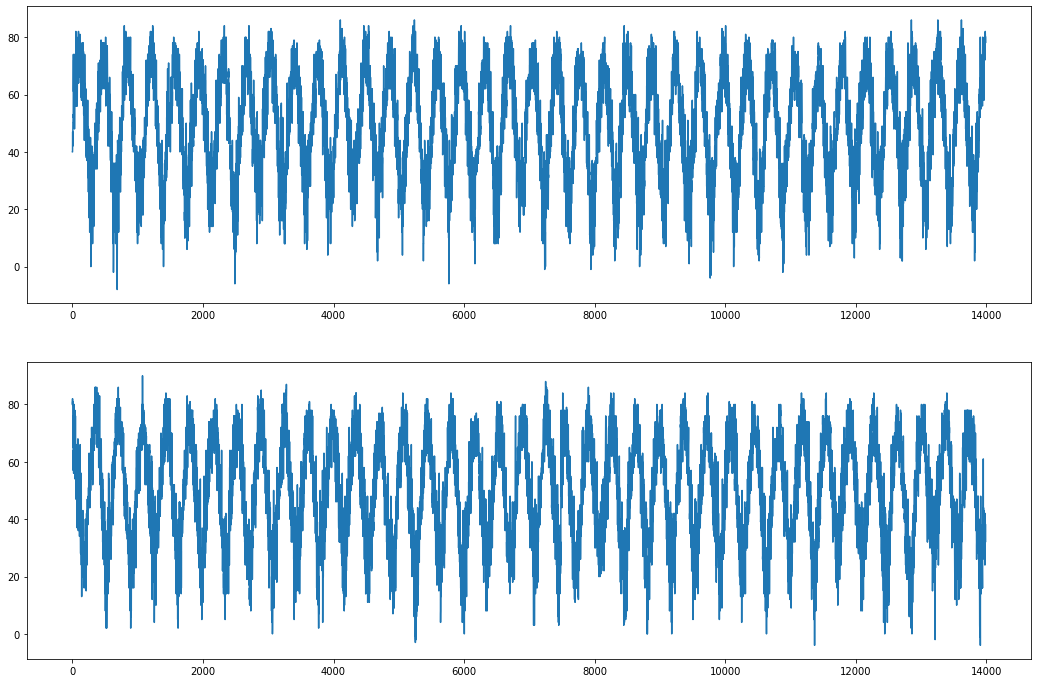

In [0]:
fig, ax = plt.subplots(2, 1, figsize = (18, 12))
ax[0].plot(weather[:13992, 0])
ax[1].plot(weather[13992:, 0])

In figure above the most salient characteristic is annual cycles in temperatures across seasons.

If we do short-term predictions (e.g. using data from the last 30 days to predict temperature in the next day), these seasonal cycles are relevant, not not useful to our model.  Here is a plot of the daily average temperature for just the last 30 days in the data set to see what kinds of dynamics our model will actually be able to use:

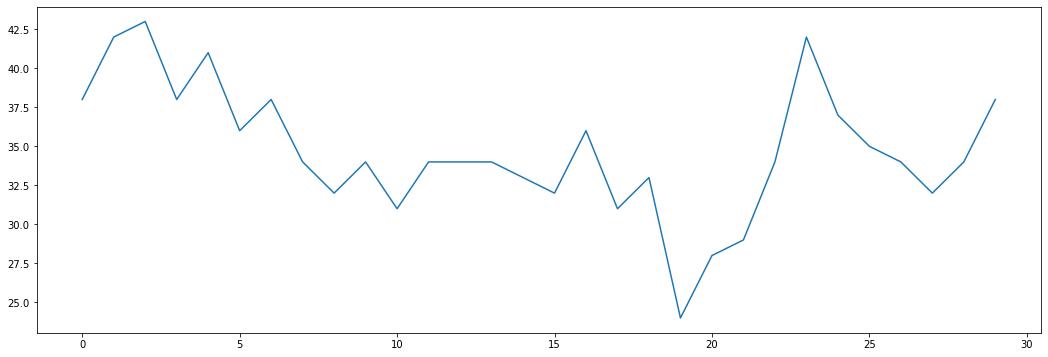

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (18, 6))
ax.plot(weather[-30:, 0])

We will explore models that use dew point, humidity, sea level pressure, visibility, wind speed, and precipitation in past 10 days to predict the temperature for the next day.

#### Approach to train/validation/test split

 * Rather than getting a random split, with time series data it's common to divide the data into contiguous blocks, with the train set being the beginning of the time series, the validation set next, and the test set last.  In this way, you never look at "future" data as part of the training or validation set.
 * We'll use the first 16896 observations (evenly divisible by a batch size of 128, about 60% of the data set) for the training set, the next 5632 (divisible by 128, about 20% of the data set) for the validation set, and the final 5456 observations for the test set.
 * Rather than explicitly splitting the data, we'll keep track of these indices and create a generator for each data set that knows about the data set it should use.

#### Standardize input features

We need to standardize the explanatory variables, as usual.

In [0]:
weather.shape

(27984, 7)

In [0]:
print(27984 * .6)
print(27984 * .8)

16790.399999999998
22387.2


In [0]:
# when standardizing, calculate the mean and standard deviation based on
# only the training set, but standardize the full data set.
train_mean = weather[:16896, 1:].mean(axis=0)
weather[:, 1:] = weather[:, 1:] - train_mean
train_std = weather[:16896, 1:].std(axis=0)
weather[:, 1:] = weather[:, 1:] / train_std

## Generators

We define generators for batches of observations.  This code is straight from the book.  Here are highlights:

 * lookback is how many days of past data we will use to predict the next day.  (We set this to 30 when calling the generator below)
 * delay is the number of days into the future we want to predict
 * min_index and max_index define the start and end points for the data set (i.e., if this will be a generator for the validation set, where are the starting and ending indices for the validation set?)
 * shuffle is a boolean saying whether we want the data to be yielded in a random order when assembling batches.  This can be important for the training set when the order of the data is meaningful.
 * batch_size is the batch size
 * step is not really meaningful for our data set.

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

In [0]:
train_gen = generator(weather,
                      lookback=30,
                      delay=1,
                      min_index=0,
                      max_index=16896,
                      shuffle=True,
                      step=1,
                      batch_size=128)
val_gen = generator(weather,
                    lookback=30,
                    delay=1,
                    min_index=16897,
                    max_index=22528,
                    shuffle=False,
                    step=1,
                    batch_size=128)
test_gen = generator(weather,
                     lookback=30,
                     delay=1,
                     min_index=22529,
                     max_index=None,
                     shuffle=False,
                     step=1,
                     batch_size=128)

train_steps = (16896 - lookback) // batch_size
val_steps = (22528 - 16897 - lookback) // batch_size
tes_steps = (len(weather) - 22528 - lookback) // batch_size

# Baseline Approaches

Let's consider two baseline models that don't use the time structure of the data fully.  This will let us really understand how useful accounting for time structure with an RNN is.

## Baseline 1: Predict most recent day's temperature

With this approach, we just use the most recent day's temperature to predict the next day's temperature.  This is clearly not the best possible model, but it shows what a simple approach can do, and gives us a number to beat.

To do this, we:
 * Generate a validation set batch (we will be comparing validation set performance of methods). The X for each batch is of shape (batch_size, T, p), and the y is of shape (batch_size,)
 * Extract the predicted values as `preds = X[:, -1, 0]`
    * From every observation 1 through batch_size (first :)
    * Last time point (-1 for second index)
    * "feature" at index 0 in our data set is temperature
 * Calculate the vector of differences `preds - y`
 * Calculate the absolute value of these differences
 * Aggregate the absolute errors across all batches
 * Take the mean absolute error (MAE)

Mean absolute error is $MAE = \sum_{i = 1}^m |\hat{y}_i - y_i|$.  This is sometimes used instead of MSE or RMSE because it's a little more interpretable.  It also penalizes "very wrong" predictions less than MSE.

In [0]:
batch_maes = []
for step in range(val_steps):
    X, y = next(val_gen)
    preds = X[:, -1, 0]
    mae = np.mean(np.abs(preds - y))
    batch_maes.append(mae)
print(np.mean(batch_maes))

7.280341569767442


On average, this basic approach to prediction is off by a little over 7 degrees F.

### Baseline 2: "Static" dense neural network

We'll fit a basic neural network with one dense hidden layer of 32 units using a relu activation.

The one thing that's tricky is that our features are organized in the shape (batch_size, T, p).  A dense layer expects a vector as input, not a 2-dimensional array.  Therefore, the first layer of our network must be a flatten layer.

In [0]:
samples, targets = next(val_gen)

In [0]:
static_model = models.Sequential()
static_model.add(layers.Flatten(input_shape=(lookback, weather.shape[-1])))
static_model.add(layers.Dense(32, activation='relu'))
static_model.add(layers.Dense(1))

static_model.compile(optimizer='rmsprop', loss='mae')
static_history = static_model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
131/131 [==============================] - 2s 18ms/step - loss: 7.2360 - val_loss: 7.0131
Epoch 2/40
131/131 [==============================] - 1s 7ms/step - loss: 6.5606 - val_loss: 6.9317
Epoch 3/40
131/131 [==============================] - 1s 7ms/step - loss: 6.4023 - val_loss: 6.7966
Epoch 4/40
131/131 [==============================] - 1s 7ms/step - loss: 6.3441 - val_loss: 6.5505
Epoch 5/40
131/131 [==============================] - 1s 7ms/step - loss: 6.2353 - val_loss: 7.5695
Epoch 6/40
131/131 [==============================] - 1s 7ms/step - loss: 6.0918 - val_loss: 6.6926
Epoch 7/40
131/131 [==============================] - 1s 7ms/step - loss: 6.0759 - val_loss: 6.3674
Epoch 8/40
131/131 [==============================] - 1s 7ms/step - loss: 6.1025 - val_loss: 6.3329
Epoch 9/40
131/131 [==============================] - 1s 8ms/step - loss: 6.0064 - val_loss: 6.6614
Epoch 10/40
131/131 [==============================] - 1s 7ms/step - loss: 5.9868 - val_loss: 6.149

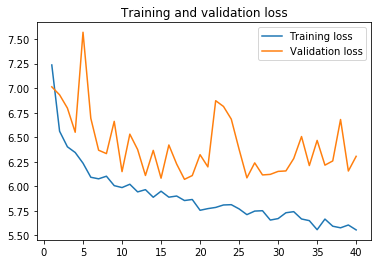

In [0]:
loss = static_history.history['loss']
val_loss = static_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This basic neural network is better than just predicting the most recent day's temperature, reducing mean absolute error by about 1 degree F.

# Recurrent Network Architectures

### 1. SimpleRNN

Let's start with a SimpleRNN.  Add a SimpleRNN layer to the network with 32 units and `input_shape = (None, weather.shape[-1])`  (You could also specify the number of time points per sequence as the first dimension of the input if you want, but this is not necessary.)

In [0]:
rnn_model = models.Sequential()
rnn_model.add(layers.SimpleRNN(32, input_shape=(None, weather.shape[-1])))
rnn_model.add(layers.Dense(1))

rnn_model.compile(optimizer='rmsprop', loss='mae')
rnn_history = rnn_model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
131/131 [==============================] - 3s 24ms/step - loss: 43.9387 - val_loss: 40.8594
Epoch 2/40
131/131 [==============================] - 2s 12ms/step - loss: 38.8928 - val_loss: 36.4083
Epoch 3/40
131/131 [==============================] - 2s 11ms/step - loss: 34.6175 - val_loss: 32.1983
Epoch 4/40
131/131 [==============================] - 2s 12ms/step - loss: 30.4704 - val_loss: 28.3554
Epoch 5/40
131/131 [==============================] - 2s 12ms/step - loss: 26.6928 - val_loss: 24.8085
Epoch 6/40
131/131 [==============================] - 2s 12ms/step - loss: 23.4511 - val_loss: 21.6412
Epoch 7/40
131/131 [==============================] - 2s 12ms/step - loss: 20.4363 - val_loss: 18.7509
Epoch 8/40
131/131 [==============================] - 2s 12ms/step - loss: 17.6847 - val_loss: 16.1904
Epoch 9/40
131/131 [==============================] - 2s 12ms/step - loss: 15.1422 - val_loss: 13.9061
Epoch 10/40
131/131 [==============================] - 2s 12ms/step - los

Run the code below to plot your training and validation set MAE vs epoch.

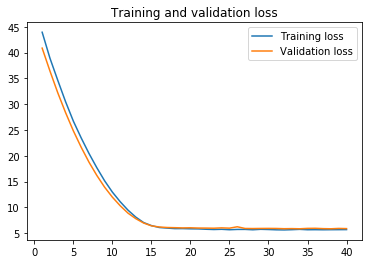

In [0]:
loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2. How does validation set loss for your simple RNN compare to the validation set loss for the baseline approaches?

Validation set loss for the simple RNN has settled down at a mean absolute error of about 5.9 degrees F.  This is slightly better than the static neural network model.

### 3. LSTM Model
Try an LSTM model.  This is probably your default/most common choice for an RNN structure.  Add an LSTM layer to the network with 32 units and `input_shape = (None, weather.shape[-1])`  (You could also specify the number of time points per sequence as the first dimension of the input if you want, but this is not necessary.)

You will note that this is somewhat slower to train than the simple RNN model.

In [0]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(32,
  input_shape=(None, weather.shape[-1])))
lstm_model.add(layers.Dense(1))

lstm_model.compile(optimizer='rmsprop', loss='mae')
lstm_history = lstm_model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
131/131 [==============================] - 7s 56ms/step - loss: 44.0492 - val_loss: 39.8034
Epoch 2/40
131/131 [==============================] - 5s 41ms/step - loss: 37.2169 - val_loss: 34.9752
Epoch 3/40
131/131 [==============================] - 5s 41ms/step - loss: 33.2631 - val_loss: 31.1001
Epoch 4/40
131/131 [==============================] - 6s 42ms/step - loss: 29.5894 - val_loss: 27.4425
Epoch 5/40
131/131 [==============================] - 6s 42ms/step - loss: 26.0706 - val_loss: 24.0597
Epoch 6/40
131/131 [==============================] - 5s 42ms/step - loss: 22.6948 - val_loss: 21.0106
Epoch 7/40
131/131 [==============================] - 6s 42ms/step - loss: 19.9674 - val_loss: 18.2517
Epoch 8/40
131/131 [==============================] - 6s 42ms/step - loss: 17.1002 - val_loss: 15.7587
Epoch 9/40
131/131 [==============================] - 5s 41ms/step - loss: 14.8977 - val_loss: 13.5977
Epoch 10/40
131/131 [==============================] - 5s 41ms/step - los

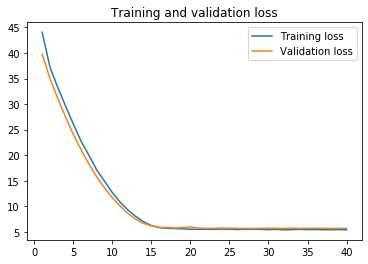

In [0]:
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 4. How does validation set loss for your LSTM model compare to the validation set loss for the baseline approaches and simple RNN?

Validation set loss for the LSTM model settled down at a mean absolute error of about 5.7 degrees F.  This is again a slight improvement over the simple RNN model.

### 5. GRU Model

Try a GRU model.  This is a little less common than LSTM, but still worth checking out.  Add a GRU layer to the network with 32 units and `input_shape = (None, weather.shape[-1])`  (You could also specify the number of time points per sequence as the first dimension of the input if you want, but this is not necessary.)

In [0]:
gru_model = models.Sequential()
gru_model.add(layers.GRU(32, input_shape=(None, weather.shape[-1])))
gru_model.add(layers.Dense(1))

gru_model.compile(optimizer='rmsprop', loss='mae')
gru_history = gru_model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
131/131 [==============================] - 7s 50ms/step - loss: 45.4447 - val_loss: 40.6254
Epoch 2/40
131/131 [==============================] - 4s 33ms/step - loss: 38.3114 - val_loss: 36.1199
Epoch 3/40
131/131 [==============================] - 4s 33ms/step - loss: 34.2460 - val_loss: 32.0743
Epoch 4/40
131/131 [==============================] - 4s 34ms/step - loss: 30.4712 - val_loss: 28.2395
Epoch 5/40
131/131 [==============================] - 4s 33ms/step - loss: 26.7084 - val_loss: 24.7070
Epoch 6/40
131/131 [==============================] - 4s 33ms/step - loss: 23.3998 - val_loss: 21.5359
Epoch 7/40
131/131 [==============================] - 4s 34ms/step - loss: 20.4944 - val_loss: 18.6523
Epoch 8/40
131/131 [==============================] - 4s 34ms/step - loss: 17.5577 - val_loss: 16.0713
Epoch 9/40
131/131 [==============================] - 5s 35ms/step - loss: 14.8704 - val_loss: 13.7629
Epoch 10/40
131/131 [==============================] - 4s 34ms/step - los

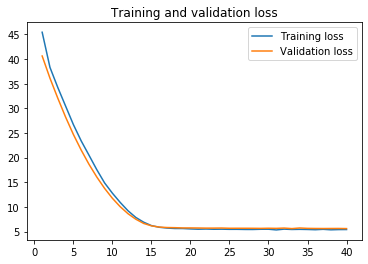

In [0]:
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
gru_model = models.Sequential()
gru_model.add(layers.GRU(32, input_shape=(None, weather.shape[-1])))
gru_model.add(layers.Dense(1))

gru_model.compile(optimizer='rmsprop', loss='mae')
history = gru_model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

### 6. How does validation set loss for your GRU model compare to the validation set loss for the baseline approaches, RNN, and LSTM model above?

The GRU is the best of the models we've looked at.

### 7. Pick your favorite of the models you've tried so far.  Refit it to the combined training and validation sets, and obtain a test set MAE.
You will need to create a new generator by calling the `generator()` function defined above.

In [0]:
# create your generator.  You just need to specify the min and max indices.
train_val_gen = generator(weather,
                      lookback=30,
                      delay=1,
                      min_index=0,
                      max_index=22528,
                      shuffle=True,
                      step=1,
                      batch_size=128)

Now fit your model.  You will need to set `steps_per_epoch = train_steps + val_steps` since you've combined the training and validation set data.

In [0]:
gru_model = models.Sequential()
gru_model.add(layers.GRU(32, input_shape=(None, weather.shape[-1])))
gru_model.add(layers.Dense(1))

gru_model.compile(optimizer='rmsprop', loss='mae')
history = gru_model.fit_generator(train_val_gen,
                              steps_per_epoch=train_steps + val_steps,
                              epochs=40)

Epoch 1/40
174/174 [==============================] - 9s 52ms/step - loss: 43.4224
Epoch 2/40
174/174 [==============================] - 6s 32ms/step - loss: 35.7554
Epoch 3/40
174/174 [==============================] - 6s 32ms/step - loss: 30.6685
Epoch 4/40
174/174 [==============================] - 6s 32ms/step - loss: 25.7333
Epoch 5/40
174/174 [==============================] - 6s 33ms/step - loss: 21.5813
Epoch 6/40
174/174 [==============================] - 6s 33ms/step - loss: 17.8288
Epoch 7/40
174/174 [==============================] - 6s 32ms/step - loss: 14.4717
Epoch 8/40
174/174 [==============================] - 6s 33ms/step - loss: 11.7554
Epoch 9/40
174/174 [==============================] - 6s 32ms/step - loss: 9.4691
Epoch 10/40
174/174 [==============================] - 6s 32ms/step - loss: 7.7445
Epoch 11/40
174/174 [==============================] - 6s 32ms/step - loss: 6.6037
Epoch 12/40
174/174 [==============================] - 6s 32ms/step - loss: 5.9505
Epoch

Evaluate your model's performance on the test set using the evaluate_generator function.

In [0]:
gru_model.evaluate_generator(test_gen, steps=tes_steps)

5.4872979039237615